In [1]:
from random import shuffle
import csv
import matplotlib.pyplot as plt
import os
import sklearn.metrics
import tensorflow as tf

In [49]:
def auc_dump(
    chkpt_path,
    dataset_name = "nyt2",
    encoder = "pcnn",
    selector = "att",
    l2_lambd = 0.0,
    batch_size = 64):
    data_dir = os.path.join("data", dataset_name)
    preprocessed_data_dir = get_preprocessed_dir(data_dir)
    if not os.path.exists(preprocessed_data_dir):
        os.mkdir(preprocessed_data_dir)

    #preprocessor_batch(data_dir)

    from src.model import Model
    tf.reset_default_graph()
    _, word_vec_mat = load_word_vec(os.path.join("data", dataset_name))
    max_classes = 53
    model = Model(word_vec_mat, encoder = encoder, selector=selector, no_of_classes=max_classes)
    print("Setting max class size to : ", max_classes)
    train_data = load_data(preprocessed_data_dir, max_classes)
    dev_data = load_data(preprocessed_data_dir, max_classes, "test")


    n_epochs = 4
    pair_bag_loc = train_data[-1]
    pairs = list(pair_bag_loc.keys())
    dev_pair_bag_loc = dev_data[-1]
    dev_pairs = list(dev_pair_bag_loc.keys())
    dev_pairs_dict = get_dev_pairs_dict(dev_pairs)
    n_dev_batches = len(dev_pairs) // batch_size

    # Load model from checkpoint
    model.mloader(os.path.join("saved", "models", chkpt_path))
    
    def na_nonNA(pairs):
        not_NA_rels = 0
        naPairs = []
        nonNaPairs = []
        for k in pairs:
            if k.split("#")[2] != "0":
                nonNaPairs.append(k)
            else:
                naPairs.append(k)
        return naPairs, nonNaPairs

    # Store NA and nonNA pairs from train, dev.
    trainNa, trainNonNa = na_nonNA(pairs)
    devNa, devNonNa = na_nonNA(dev_pairs)
    not_NA_rels = len(devNonNa)
    print("Pairs in train dataset NA and non NA : ", len(trainNa), len(trainNonNa))
    print("Pairs in train dataset NA and non NA : ", len(devNa), len(devNonNa))
    """
    all_words, all_pos1, all_pos2, all_masks, all_lengths, \
    all_inst_rels, pair_bag_loc = train_data
    all_dev_words, all_dev_pos1, all_dev_pos2, all_dev_masks, \
    all_dev_lengths, all_dev_inst_rels, dev_pair_bag_loc = dev_data
    """
    entPairSents = {} 
        
    import json 
    with open(os.path.join(data_dir, "test.json"), "r") as f: 
        data = json.load(f)
        for sent in data: 
          e1 = sent['head']['word'] 
          e2 = sent['tail']['word'] 
          try: 
              rel = relToId[sent['relation']] 
          except Exception as ex: 
              rel = 0 
          k = e1 + "#" + e2  
          if k in entPairSents: 
            entPairSents[k].append(sent['sentence']) 
          else: 
            entPairSents[k] = [sent['sentence']]
    with open(os.path.join(data_dir, "idToRel.json"), "r") as f: 
        idToRel = json.load(f)
    
    def dump_auc(dev_pairs = dev_pairs):
        test_res = []
        for i in range(n_dev_batches):
          batch_keys = dev_pairs[i * batch_size : (i + 1) * batch_size]
          words, pos1, pos2, inst_rels, masks, lengths, \
            rels, scope = batch_maker(dev_data, batch_keys)
          pos1[pos1 > 239] = 239
          pos2[pos2 > 239] = 239
          pos1[pos1 < 0] = 0
          pos2[pos2 < 0] = 0
          output, atts = model.test_batch(words, pos1, pos2, inst_rels, 
            masks, lengths, rels, scope)
          for i, k in enumerate(batch_keys):
            entPair = "#".join(k.split("#")[:2])
            entPairRels = dev_pairs_dict[entPair]
            for j in range(1, 53):
              correct = 0
              if j in entPairRels:
                correct = 1
              if output[i][j] > 0.01:
                test_res.append({"entPair" : entPair, 
                    "score" : output[i][j], 
                    "correct" : correct, 
                    "pred" : j, 
                    "actual" : entPairRels,
                    "atts" : atts[i][j] if selector is "att" else []})
        prec = []
        recall = []
        correct = 0
        sorted_test_result = sorted(test_res, key=lambda x: x['score'], reverse = True)

        import time
        start = time.time()

        for i, item in enumerate(sorted_test_result):
          if item["correct"]:
            correct += 1  
          prec.append(float(correct) / (i + 1))
          recall.append(float(correct) / not_NA_rels)
        with open(os.path.join("saved", "aucs", chkpt_path + "_auc"), "w") as f:
            for i, (p, r) in enumerate(zip(prec, recall)):
                f.write("{} {} {} \n".format(i, p, r))
        with open(os.path.join("saved", "aucs", chkpt_path + "_preds.csv"), "w", newline="") as f:
            preds = []
            for i, item in enumerate(sorted_test_result[:1000]):
                sents = "\n".join(entPairSents[item["entPair"]])
                temp_str = [item["entPair"], sents, idToRel[str(item["pred"])], " ",
                            "\n".join(idToRel[str(k)] for k in item["actual"]), str(item["correct"]), 
                            " ".join(str(x) for x in item["atts"]), str(item["score"])]
                print(temp_str)
                preds.append(temp_str)
            writer = csv.writer(f)
            writer.writerows(preds)
        
    dump_auc()
    print("Dumped AUC for model : {}")

In [50]:
temp = [
    ("pcnn2", "att", "pcnn2_att_nyt2_none_53_n_0_0.3328"),
    ("pcnn", "att", "pcnn_att_nyt2_none_53_n_0_0.3455"),
    ("rnn", "att", "rnn_att_nyt2_none_53_n_0_0.3330"),
    ("brnn", "att", "brnn_att_nyt2_none_53_n_0_0.3542"),
    ("pcnn2", "cross_sent_max", "pcnn2_cross_sent_max_nyt2_none_53_n_0_0.3860"),
    ("pcnn", "cross_sent_max", "pcnn_cross_sent_max_nyt2_none_53_n_0_0.3692"),
    ("rnn", "cross_sent_max", "rnn_cross_sent_max_nyt2_none_53_n_0_0.3853"),
    ("brnn", "cross_sent_max", "brnn_cross_sent_max_nyt2_none_53_n_0_0.3882"),
    ]

for encoder_, selector_, path_ in temp:
    auc_dump(path_, dataset_name = "nyt2", encoder = encoder_, selector = selector_)

Creating model with encoder and selector :  pcnn2 att
121 (?, 120, 80)
121 (?, 120, 80)
(?, 240)
Created model with no bootstrapping, bs val : 0.0
Setting max class size to :  53
path : saved/models/pcnn2_att_nyt2_none_53_n_0_0.3328
INFO:tensorflow:Restoring parameters from saved/models/pcnn2_att_nyt2_none_53_n_0_0.3328
Pairs in train dataset NA and non NA :  262336 18252
Pairs in train dataset NA and non NA :  94917 1950
['Wisconsin#Madison', "Ryan has coached at Wisconsin 's main campus in Madison since 2001 .\nThe proposal has its critics , many of whom call it nothing less than modern-day Prohibition , and an assault on personal freedom and the free market that flies in the face of Madison 's traditional liberalism and Wisconsin 's entrenched drinking culture .\nBARNARD -- Allan , who was born in Madison , Wisconsin on August 8th , 1918 , died on Monday , January 22nd , of complications from Parkinson 's disease in Forest Hills , New York .\nThe decision to award the contract -- th

Creating model with encoder and selector :  pcnn att
121 (?, 120, 230)
121 (?, 120, 230)
(?, 690)
Created model with no bootstrapping, bs val : 0.0
Setting max class size to :  53
path : saved/models/pcnn_att_nyt2_none_53_n_0_0.3455
INFO:tensorflow:Restoring parameters from saved/models/pcnn_att_nyt2_none_53_n_0_0.3455
Pairs in train dataset NA and non NA :  262336 18252
Pairs in train dataset NA and non NA :  94917 1950
['Suffolk County#Huntington', "For example , the parks department in Suffolk County , on Long Island , learned through letters and phone calls that unleashed dogs were posing a nuisance to neighbors of Coindre Hall Park , a 33-acre former estate in Huntington where dogs traditionally have run free on a wide sloping lawn not hemmed in by any fences .\nJon Cooper , a Democrat from of Huntington , has sponsored a bill in the Suffolk County Legislature that would mandate that the county 's diesel fleet use ultra-low-sulfur diesel fuel and filtering devices on all engines ,

Creating model with encoder and selector :  rnn att
74 :  (?, 120, 60)
Using gru cell
78 :  (?, 120, 230)
74 :  (?, 120, 60)
Using gru cell
78 :  (?, 120, 230)
(?, 230)
Created model with no bootstrapping, bs val : 0.0
Setting max class size to :  53
path : saved/models/rnn_att_nyt2_none_53_n_0_0.3330
INFO:tensorflow:Restoring parameters from saved/models/rnn_att_nyt2_none_53_n_0_0.3330
Pairs in train dataset NA and non NA :  262336 18252
Pairs in train dataset NA and non NA :  94917 1950
['Abdou Diouf#Senegal', "The young men in the photo went on to do great things : Mr. Camara 's classmate Abdou Diouf became Senegal 's second president .", '/people/person/nationality', ' ', 'NA', '0', '1.0', '0.99521166']
['Denise Karbon#Italy', 'Maria Pietilae-Holmner of Sweden took the silver and Denise Karbon of Italy the bronze .', '/people/person/nationality', ' ', '/people/person/nationality', '1', '1.0', '0.99318343']
['Sani Abacha#Nigeria', "But in the mid-1990s , Mr. Young found himself urgi

Creating model with encoder and selector :  brnn att
Using gru cell
Using gru cell
Using gru cell
Using gru cell
(?, 460)
Created model with no bootstrapping, bs val : 0.0
Setting max class size to :  53
path : saved/models/brnn_att_nyt2_none_53_n_0_0.3542
INFO:tensorflow:Restoring parameters from saved/models/brnn_att_nyt2_none_53_n_0_0.3542
Pairs in train dataset NA and non NA :  262336 18252
Pairs in train dataset NA and non NA :  94917 1950
['California#Long Beach', "This year 's Tour of California is expected to draw large crowds as it travels 640 miles through central California and down the coast to Long Beach .\nThis year 's Tour of California is expected to draw large crowds as it travels 640 miles through central California and down the coast to Long Beach .\nWhile they rarely compare notes -LRB- and even more rarely track results -RRB- , California institutions like the San Diego Museum of Art , the Museum of Latin American Art in Long Beach , the Getty Museum , the Los Ange

Creating model with encoder and selector :  pcnn2 cross_sent_max
121 (?, 120, 80)
121 (?, 120, 80)
(?, 240)
Created model with no bootstrapping, bs val : 0.0
Setting max class size to :  53
path : saved/models/pcnn2_cross_sent_max_nyt2_none_53_n_0_0.3860
INFO:tensorflow:Restoring parameters from saved/models/pcnn2_cross_sent_max_nyt2_none_53_n_0_0.3860
Pairs in train dataset NA and non NA :  262336 18252
Pairs in train dataset NA and non NA :  94917 1950
['Maryland#Annapolis', "RINEHART -- George Henry Doran , of Annapolis , Maryland , died Tuesday , April 10 , at age 78 .\nMartin J. O'Malley was sworn in as governor in a ceremony in Annapolis that included a surprise guest , Speaker Nancy Pelosi of California , a Maryland native .\nA memorial service will be held in Annapolis , Maryland , on a date to be announced .\nMaryland Seafood Festivals A directory of spring and summer seafood festivals in Maryland is available at marylandseafood.org or by sending a stamped , self-addressed env

Creating model with encoder and selector :  pcnn cross_sent_max
121 (?, 120, 230)
121 (?, 120, 230)
(?, 690)
Created model with no bootstrapping, bs val : 0.0
Setting max class size to :  53
path : saved/models/pcnn_cross_sent_max_nyt2_none_53_n_0_0.3692
INFO:tensorflow:Restoring parameters from saved/models/pcnn_cross_sent_max_nyt2_none_53_n_0_0.3692
Pairs in train dataset NA and non NA :  262336 18252
Pairs in train dataset NA and non NA :  94917 1950
['Eric E. Schmidt#Google', "Eric E. Schmidt , who is chief executive of Google as well as a member of Apple 's board , and Jerry Yang , co-founder of Yahoo , came on stage to endorse the new hand-held . ''\nIn recent weeks , Google 's chief executive , Eric E. Schmidt , has said that the company will soon unveil new tools that will make it easier for copyright owners to spot their content on YouTube .\nWe think we can add value to this important medium by delivering more relevant ads to viewers , providing better accountability for adve

Creating model with encoder and selector :  rnn cross_sent_max
74 :  (?, 120, 60)
Using gru cell
78 :  (?, 120, 230)
74 :  (?, 120, 60)
Using gru cell
78 :  (?, 120, 230)
(?, 230)
Created model with no bootstrapping, bs val : 0.0
Setting max class size to :  53
path : saved/models/rnn_cross_sent_max_nyt2_none_53_n_0_0.3853
INFO:tensorflow:Restoring parameters from saved/models/rnn_cross_sent_max_nyt2_none_53_n_0_0.3853
Pairs in train dataset NA and non NA :  262336 18252
Pairs in train dataset NA and non NA :  94917 1950
['Laure Manaudou#France', "Laure Manaudou of France won her latest gold medal in the women 's 400 freestyle , looking less than elated after she realized that she had failed to break her own world record .\nLaure Manaudou , France 's anchor-leg swimmer , has four medals .\nFrance 's Laure Manaudou , who successfully defended her title in the 400 freestyle Sunday , qualified for two more finals Monday , in the 100 backstroke and 1,500 freestyle .\nLaure Manaudou of Fran

Creating model with encoder and selector :  brnn cross_sent_max
Using gru cell
Using gru cell
Using gru cell
Using gru cell
(?, 460)
Created model with no bootstrapping, bs val : 0.0
Setting max class size to :  53
path : saved/models/brnn_cross_sent_max_nyt2_none_53_n_0_0.3882
INFO:tensorflow:Restoring parameters from saved/models/brnn_cross_sent_max_nyt2_none_53_n_0_0.3882
Pairs in train dataset NA and non NA :  262336 18252
Pairs in train dataset NA and non NA :  94917 1950
['Punjab#India', "Jagjit Singh Chauhan , the Sikh who led a violent separatist movement in India 's northern Punjab State , died at his home in Tanda , India , on April 4 .\nHe puts the start of rapid decline at the mid-1990s , as India began liberalizing its economy , more people began traveling abroad and satellite television arrived in the villages of Punjab .\nSikhs , who trace their religion to the late-15th-century Punjab region of what are now Pakistan and India , number some 24 million around the world an

In [6]:
import seaborn as sns
temp = [
    ("spcnn", "att", "pcnn2_att_nyt2_none_53_n_0_0.3328"),
    ("pcnn", "att", "pcnn_att_nyt2_none_53_n_0_0.3455"),
    ("rnn", "att", "rnn_att_nyt2_none_53_n_0_0.3330"),
    ("brnn", "att", "brnn_att_nyt2_none_53_n_0_0.3542"),
    ("spcnn", "cross_sent_max", "pcnn2_cross_sent_max_nyt2_none_53_n_0_0.3860"),
    ("pcnn", "cross_sent_max", "pcnn_cross_sent_max_nyt2_none_53_n_0_0.3692"),
    ("rnn", "cross_sent_max", "rnn_cross_sent_max_nyt2_none_53_n_0_0.3853"),
    ("brnn", "cross_sent_max", "brnn_cross_sent_max_nyt2_none_53_n_0_0.3882"),
    ]
auc_curves = {}
for k in temp:
    p = []
    r = []
    with open(os.path.join("saved", "aucs", k[2] + "_auc"), "r") as f:
        for line in f:
            _, p_, r_ = line.split()
            p.append(float(p_))
            r.append(float(r_))
    i = 0
    while r[i] < 0.8:
        i += 1
    auc_curves[k] = (p[:i], r[:i])

k = ("bgwa", "att")
import numpy as np
bgwa_p = np.load(os.path.join("saved", "aucs", "bgwa_precision.npy"))
bgwa_r = np.load(os.path.join("saved", "aucs", "bgwa_recall.npy"))

path = "saved/aucs/att_soft.auc2"
soft_p = []
soft_r = []
with open(path, "r") as f:
    for line in f:
        soft_p.append(float(line.split()[0]))
        soft_r.append(float(line.split()[1]))


('pcnn', 'att', 'pcnn_att_nyt2_none_53_n_0_0.3455')
('brnn', 'att', 'brnn_att_nyt2_none_53_n_0_0.3542')


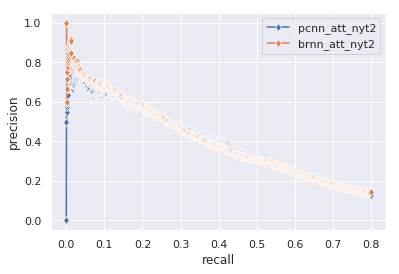

In [123]:
# Plot across att
sns.set()

for k in temp:
    if k[1] == "att" and (k[0] is "pcnn" or k[0] is "brnn"):
        print(k)
        sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2", marker="d").set(xlabel="recall", ylabel="precision")

# Plot across cross_sent_max


('spcnn', 'cross_sent_max', 'pcnn2_cross_sent_max_nyt2_none_53_n_0_0.3860')
('brnn', 'cross_sent_max', 'brnn_cross_sent_max_nyt2_none_53_n_0_0.3882')


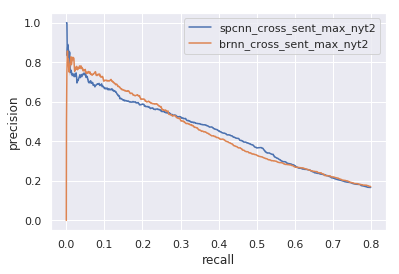

In [107]:
for k in temp:
    if "cross" in k[1] and (k[0] is "spcnn" or k[0] is "brnn"):
        print(k)
        sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")


('spcnn', 'att', 'pcnn2_att_nyt2_none_53_n_0_0.3328')
('spcnn', 'cross_sent_max', 'pcnn2_cross_sent_max_nyt2_none_53_n_0_0.3860')


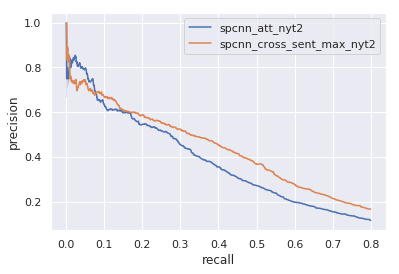

In [108]:
for k in temp:
    if "spcnn" in k[0]:
        print(k)
        sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")
plt.savefig("pcnn2_comp.png")

('brnn', 'att', 'brnn_att_nyt2_none_53_n_0_0.3542')
('brnn', 'cross_sent_max', 'brnn_cross_sent_max_nyt2_none_53_n_0_0.3882')


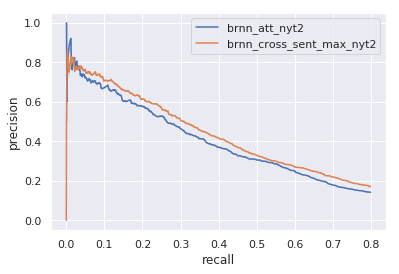

In [109]:
for k in temp:
    if "brnn" in k[0]:
        print(k)
        sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")
plt.savefig("brnn_comp.png")

('rnn', 'att', 'rnn_att_nyt2_none_53_n_0_0.3330')
('rnn', 'cross_sent_max', 'rnn_cross_sent_max_nyt2_none_53_n_0_0.3853')


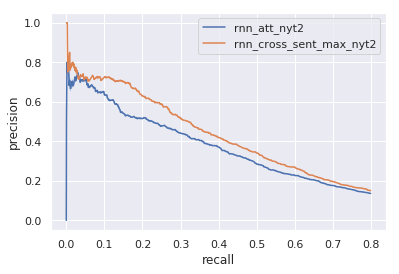

In [110]:
for k in temp:
    if "rnn" is k[0]:
        print(k)
        sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")
plt.savefig("rnn_comp.png")

('pcnn', 'att', 'pcnn_att_nyt2_none_53_n_0_0.3455')
('pcnn', 'cross_sent_max', 'pcnn_cross_sent_max_nyt2_none_53_n_0_0.3692')


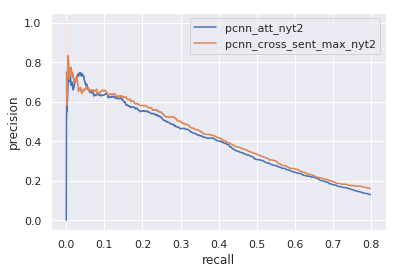

In [112]:
for k in temp:
    if "pcnn" is k[0]:
        print(k)
        sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")
plt.savefig("pcnn_comp.png")

('pcnn2', 'att', 'pcnn2_att_nyt2_none_53_n_0_0.3328')
('pcnn', 'att', 'pcnn_att_nyt2_none_53_n_0_0.3455')
('rnn', 'att', 'rnn_att_nyt2_none_53_n_0_0.3330')
('brnn', 'att', 'brnn_att_nyt2_none_53_n_0_0.3542')


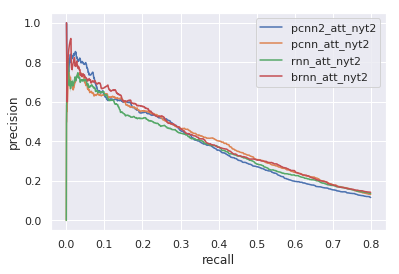

In [98]:
for k in temp:
    if "att" is k[1]:
        print(k)
        sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")
plt.savefig("att_comp.png")

('pcnn2', 'cross_sent_max', 'pcnn2_cross_sent_max_nyt2_none_53_n_0_0.3860')
('pcnn', 'cross_sent_max', 'pcnn_cross_sent_max_nyt2_none_53_n_0_0.3692')
('rnn', 'cross_sent_max', 'rnn_cross_sent_max_nyt2_none_53_n_0_0.3853')
('brnn', 'cross_sent_max', 'brnn_cross_sent_max_nyt2_none_53_n_0_0.3882')


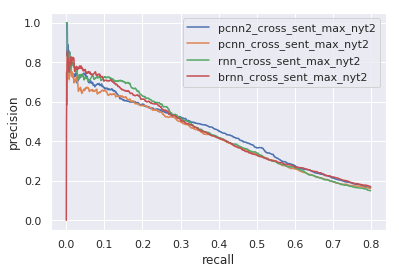

In [100]:
for k in temp:
    if "cross" in k[1]:
        print(k)
        sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")
plt.savefig("cross_comp.png")

('pcnn2', 'att', 'pcnn2_att_nyt2_none_53_n_0_0.3328')
('pcnn', 'att', 'pcnn_att_nyt2_none_53_n_0_0.3455')
('rnn', 'att', 'rnn_att_nyt2_none_53_n_0_0.3330')
('brnn', 'att', 'brnn_att_nyt2_none_53_n_0_0.3542')


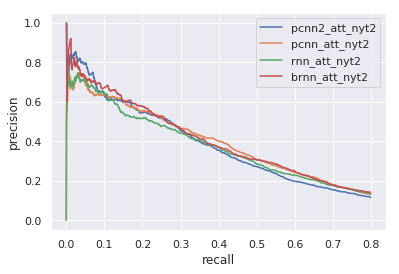

In [101]:
for k in temp:
    if "att" in k[1]:
        print(k)
        sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")
plt.savefig("att_comp.png")

In [116]:
import sklearn
import seaborn as sns
temp = [
    ("spcnn", "att", "pcnn2_att_nyt2_none_53_n_0_0.3328"),
    ("pcnn", "att", "pcnn_att_nyt2_none_53_n_0_0.3455"),
    ("rnn", "att", "rnn_att_nyt2_none_53_n_0_0.3330"),
    ("brnn", "att", "brnn_att_nyt2_none_53_n_0_0.3542"),
    ("spcnn", "cross_sent_max", "pcnn2_cross_sent_max_nyt2_none_53_n_0_0.3860"),
    ("pcnn", "cross_sent_max", "pcnn_cross_sent_max_nyt2_none_53_n_0_0.3692"),
    ("rnn", "cross_sent_max", "rnn_cross_sent_max_nyt2_none_53_n_0_0.3853"),
    ("brnn", "cross_sent_max", "brnn_cross_sent_max_nyt2_none_53_n_0_0.3882"),
    ]
for k in temp:
    p = []
    r = []
    with open(os.path.join("saved", "aucs", k[2] + "_auc"), "r") as f:
        for line in f:
            _, p_, r_ = line.split()
            p.append(float(p_))
            r.append(float(r_))
    i = 0
    while r[i] <= 0.4:
        i += 1
    p = p[:i]
    r = r[:i]
    print(k, r[-1])
    print(sklearn.metrics.auc(x = r, y = p))

('spcnn', 'att', 'pcnn2_att_nyt2_none_53_n_0_0.3328') 0.4
0.22628195966467984
('pcnn', 'att', 'pcnn_att_nyt2_none_53_n_0_0.3455') 0.4
0.2220017026879811
('rnn', 'att', 'rnn_att_nyt2_none_53_n_0_0.3330') 0.4
0.21328176125395998
('brnn', 'att', 'brnn_att_nyt2_none_53_n_0_0.3542') 0.4
0.2293514388111508
('spcnn', 'cross_sent_max', 'pcnn2_cross_sent_max_nyt2_none_53_n_0_0.3860') 0.4
0.2386967562100488
('pcnn', 'cross_sent_max', 'pcnn_cross_sent_max_nyt2_none_53_n_0_0.3692') 0.4
0.22917461448187204
('rnn', 'cross_sent_max', 'rnn_cross_sent_max_nyt2_none_53_n_0_0.3853') 0.4
0.2477439386839858
('brnn', 'cross_sent_max', 'brnn_cross_sent_max_nyt2_none_53_n_0_0.3882') 0.4
0.24475023647196756


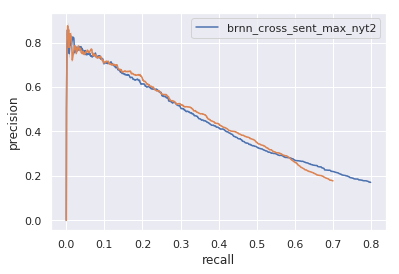

In [18]:
sns.set()
k = ("spcnn", "cross_sent_max", "pcnn2_cross_sent_max_nyt2_none_53_n_0_0.3860")
k = ("brnn", "cross_sent_max", "brnn_cross_sent_max_nyt2_none_53_n_0_0.3882")
sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")
# k = ("pcnn", "att", "pcnn_att_nyt2_none_53_n_0_0.3455")
# sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")
sns.lineplot(bgwa_r, bgwa_p)
# Plot across cross_sent_max


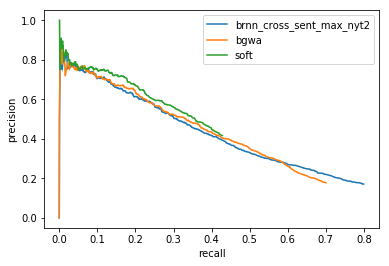

In [8]:
k = ("brnn", "cross_sent_max", "brnn_cross_sent_max_nyt2_none_53_n_0_0.3882")
sns.lineplot(auc_curves[k][1], auc_curves[k][0], label = k[0] + "_" + k[1] + "_nyt2").set(xlabel="recall", ylabel="precision")
sns.lineplot(bgwa_r, bgwa_p, label = "bgwa")
sns.lineplot(soft_r, soft_p, label = "soft")
